### Cluster characterization of gonadal immune cells (merged)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
import anndata
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './final-figures/merged/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

#### Load data with predictions from fetal liver

In [2]:
path_to_gonads = '/nfs/team292/vl6/immune_fetal_gonads/'

In [3]:
adata = sc.read(path_to_gonads + 'immune_merged_with_predictions.h5ad')
adata

AnnData object with n_obs × n_vars = 19538 × 400
    obs: 'batch', 'batch_collection', 'cryopreserved', 'individual', 'location', 'n_counts', 'n_genes', 'percent_mito', 'process', 'sample', 'sex', 'stage', 'study', 'PCW', 'sample_source', 'doublet_score', 'doublet_score_0.75', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'leiden', 'enrichment', '5v1.1', 'TP', 'clusters', 'louvain', 'clusters_manual', 'S_score', 'G2M_score', 'phase', 'liver_classifier', 'prob_B cell', 'prob_DC1', 'prob_DC2', 'prob_Early lymphoid/T lymphocyte', 'prob_Erythroblastic Island Macrophage', 'prob_HSC/MPP', 'prob_ILC precursor', 'prob_Kupffer Cell', 'prob_MEMP', 'prob_Mast cell', 'prob_Megakaryocyte', 'prob_Mono-Mac', 'prob_Mono-NK', 'prob_Monocyte', 'prob_Monocyte-DC precursor', 'prob_NK', 'prob_Neutrophil-myeloid progenitor', 'prob_VCAM1+ Erythroblastic Island Macrophage', 'prob_pDC precursor', 'prob_pre B cell', 'prob_pre pro B cell ', 'prob_pro B cell'
    var:

In [4]:
# Reset to raw 
adata = anndata.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)
adata.shape

(19538, 28497)

#### Save raw data 

In [5]:
adata.raw = adata.copy()

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 7822 genes that are detected in less than 3 cells


#### Normalize and log transform 

In [7]:
# Normalize per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log-transform the data 
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#### Filter HVG and compute Principal Component Analysis with them 

In [8]:
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Total number of cells: 19538
Total number of genes: 1953


In [9]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


#### Transfer PCA to the main adata

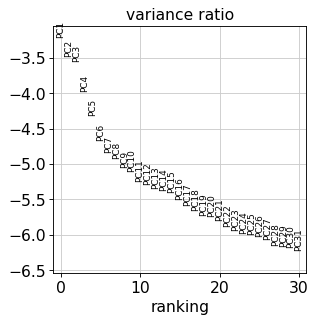

In [10]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

In [11]:
# Scale
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


#### Regress out cell cycle genes

In [12]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, random_state = 123)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    544 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    544 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['S_score', 'G2M_score']
... storing 'phase' as categorical
    finished (0:27:58)


In [44]:
g2m_genes

['HMGB2',
 'CDK1',
 'NUSAP1',
 'UBE2C',
 'BIRC5',
 'TPX2',
 'TOP2A',
 'NDC80',
 'CKS2',
 'NUF2',
 'CKS1B',
 'MKI67',
 'TMPO',
 'CENPF',
 'TACC3',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'AURKB',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'KIF20B',
 'HJURP',
 'CDCA3',
 'CDC20',
 'TTK',
 'CDC25C',
 'KIF2C',
 'RANGAP1',
 'NCAPD2',
 'DLGAP5',
 'CDCA2',
 'CDCA8',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'PSRC1',
 'ANLN',
 'LBR',
 'CKAP5',
 'CENPE',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5',
 'CENPA']

#### Batch correction using Harmony

In [13]:
# Extract PCA matrix and batch array
n_pcs = 21
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [14]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

In [15]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp



In [16]:
# Add harmony values to the anndata object
adata.obsm['X_pca'] = hem.values

In [17]:
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state=1234)

computing neighbors
    using 'X_pca' with n_pcs = 21
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)


In [18]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


#### Visualize metadata

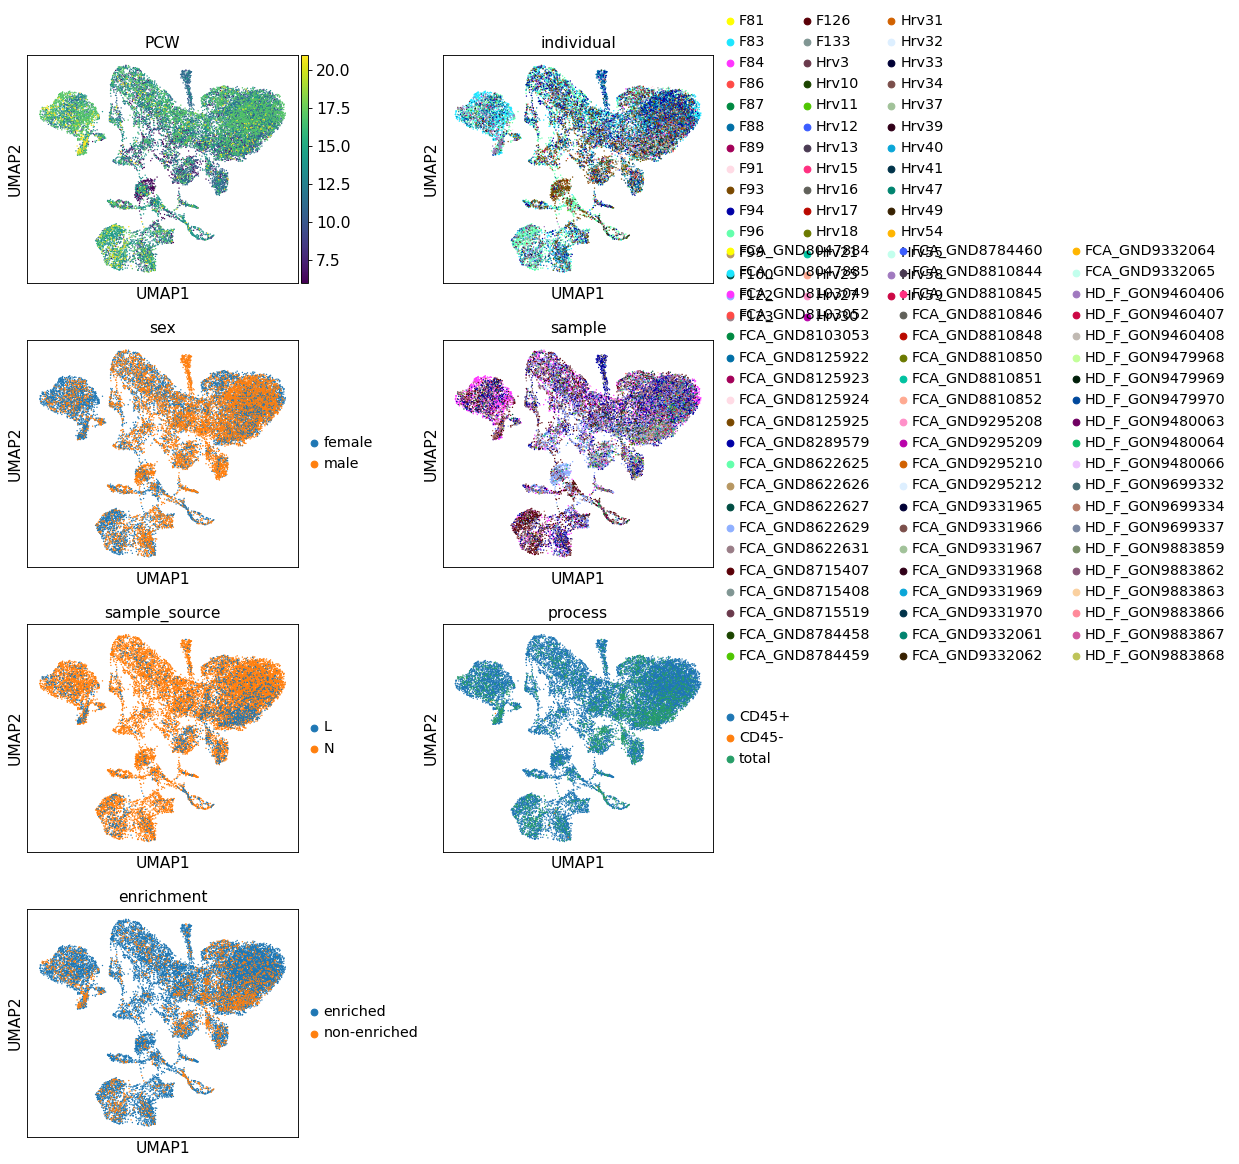

In [19]:
sc.pl.umap(adata, color=['PCW', 'individual', 'sex', 'sample', 'sample_source', 'process', 'enrichment'],
           save='.pdf', ncols = 2, wspace = 0.4)

#### Visualize predicted probabilities from liver data

In [20]:
adata.obs.columns

Index(['batch', 'batch_collection', 'cryopreserved', 'individual', 'location',
       'n_counts', 'n_genes', 'percent_mito', 'process', 'sample', 'sex',
       'stage', 'study', 'PCW', 'sample_source', 'doublet_score',
       'doublet_score_0.75', 'scrublet_score', 'scrublet_cluster_score',
       'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'leiden', 'enrichment',
       '5v1.1', 'TP', 'clusters', 'louvain', 'clusters_manual', 'S_score',
       'G2M_score', 'phase', 'liver_classifier', 'prob_B cell', 'prob_DC1',
       'prob_DC2', 'prob_Early lymphoid/T lymphocyte',
       'prob_Erythroblastic Island Macrophage', 'prob_HSC/MPP',
       'prob_ILC precursor', 'prob_Kupffer Cell', 'prob_MEMP',
       'prob_Mast cell', 'prob_Megakaryocyte', 'prob_Mono-Mac', 'prob_Mono-NK',
       'prob_Monocyte', 'prob_Monocyte-DC precursor', 'prob_NK',
       'prob_Neutrophil-myeloid progenitor',
       'prob_VCAM1+ Erythroblastic Island Macrophage', 'prob_pDC precursor',
       'prob_pre B cell', 'pr

In [21]:
probabilities = ['prob_B cell', 'prob_DC1', 'prob_DC2',
       'prob_Early lymphoid/T lymphocyte',
       'prob_Erythroblastic Island Macrophage', 'prob_HSC/MPP',
       'prob_ILC precursor', 'prob_Kupffer Cell', 'prob_MEMP',
       'prob_Mast cell', 'prob_Megakaryocyte', 'prob_Mono-Mac', 'prob_Mono-NK',
       'prob_Monocyte', 'prob_Monocyte-DC precursor', 'prob_NK',
       'prob_Neutrophil-myeloid progenitor',
       'prob_VCAM1+ Erythroblastic Island Macrophage', 'prob_pDC precursor',
       'prob_pre B cell', 'prob_pre pro B cell ', 'prob_pro B cell']

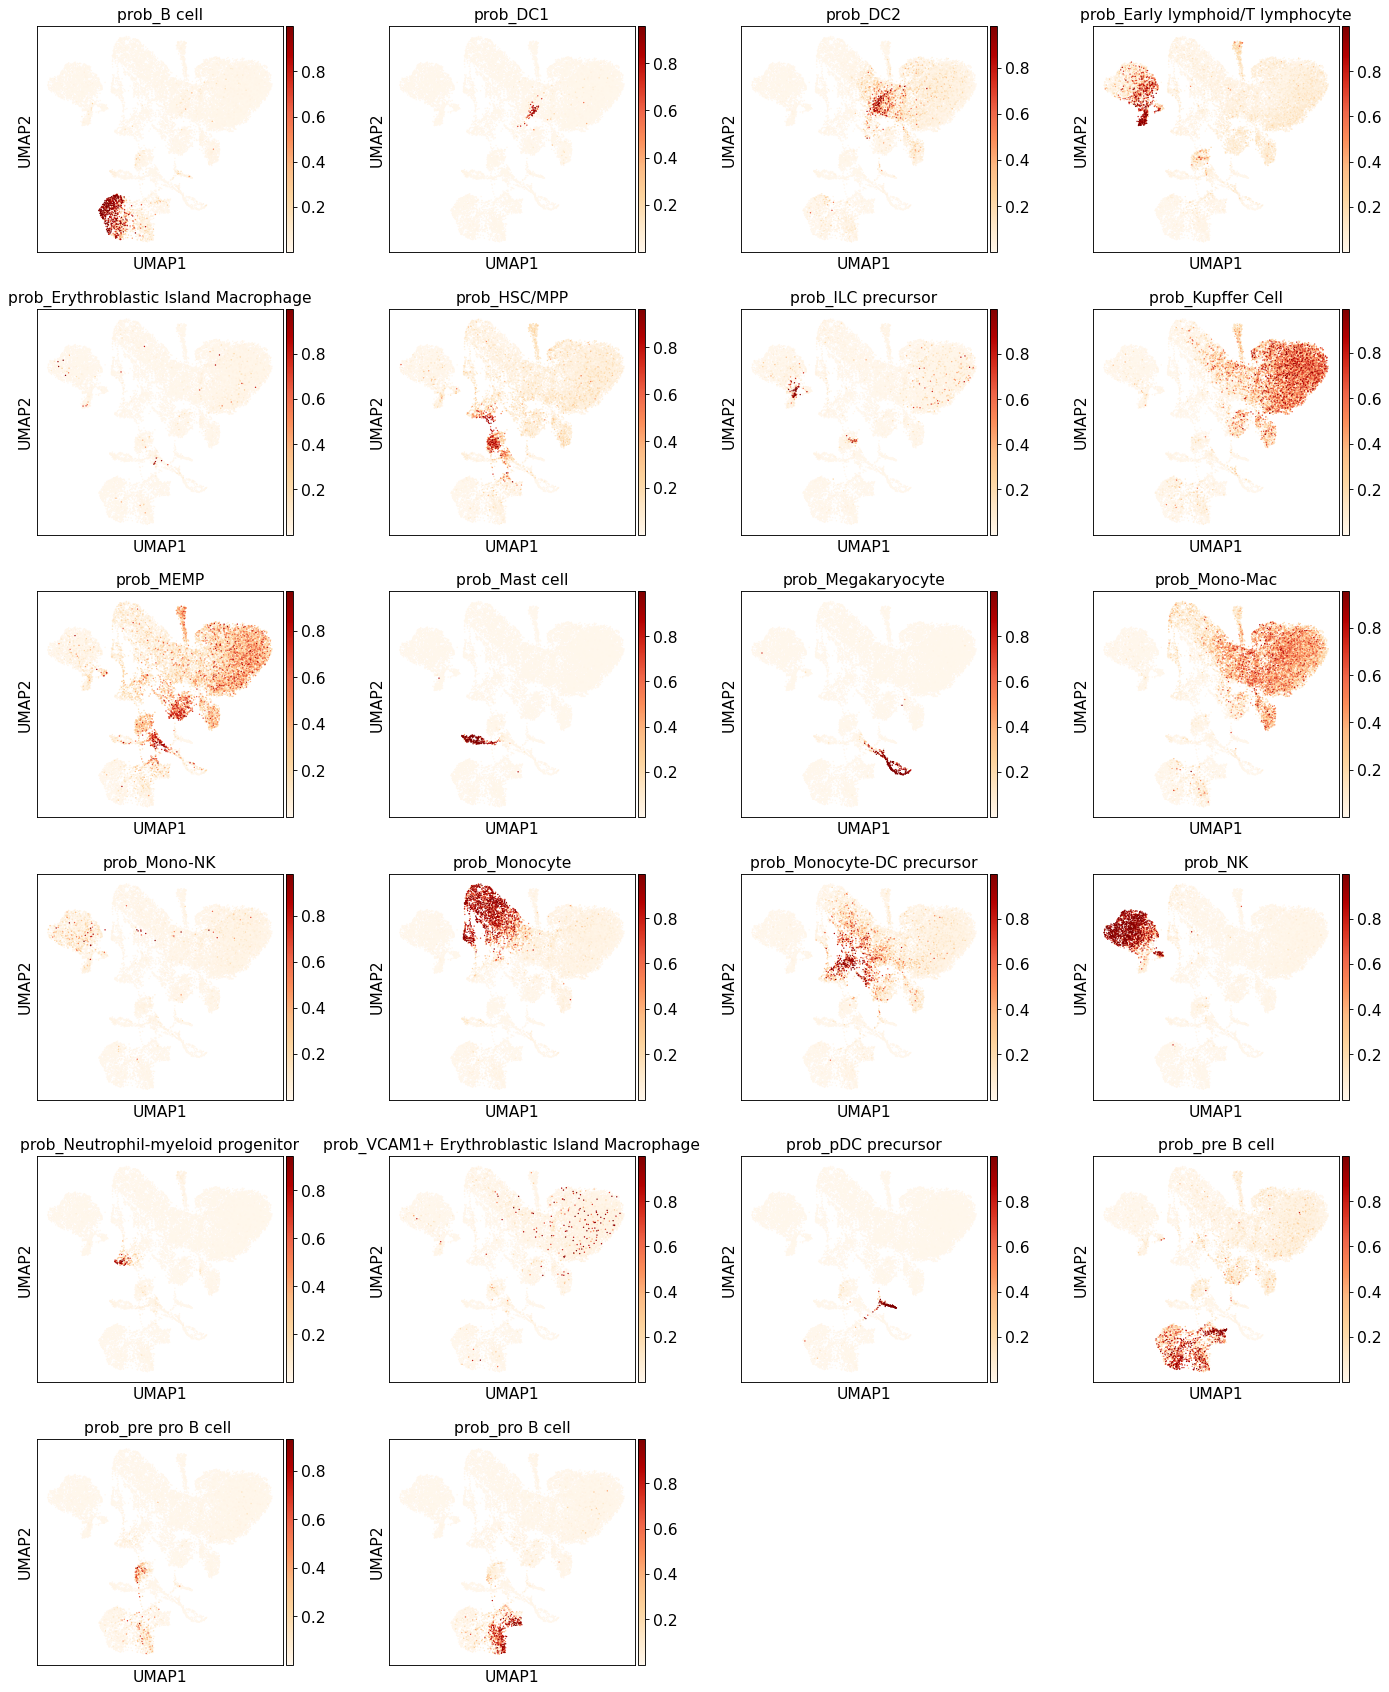

In [22]:
sc.pl.umap(adata, color = probabilities, color_map = 'OrRd', wspace = 0.3)

#### Cluster the manifold 

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


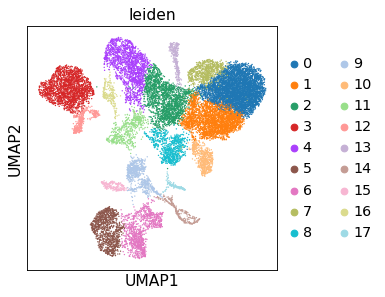

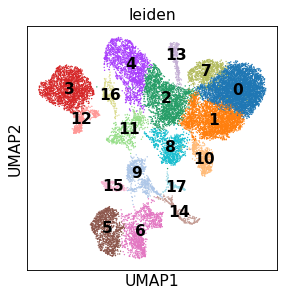

In [23]:
sc.tl.leiden(adata, resolution= 0.5) # low resolution just to identify main lineages

sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf')

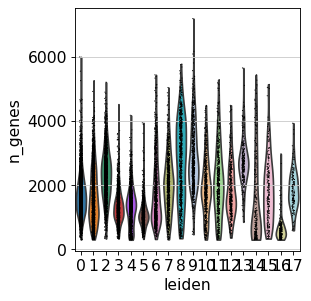

In [24]:
sc.pl.violin(adata, keys = 'n_genes', groupby = 'leiden')

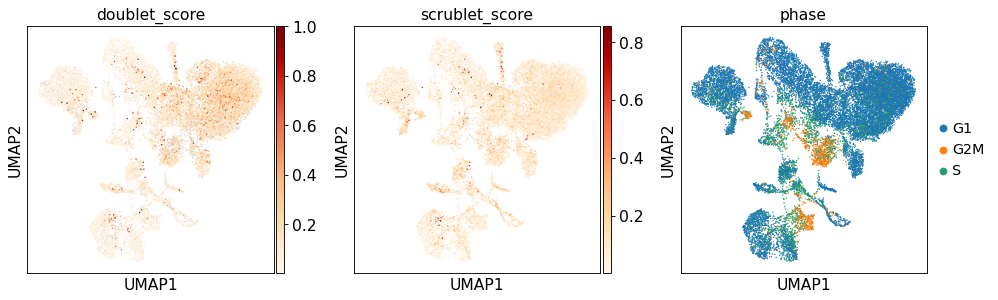

In [25]:
sc.pl.umap(adata, color =['doublet_score', 'scrublet_score', 'phase'], color_map = 'OrRd')

In [26]:
gonads_colors = ['#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

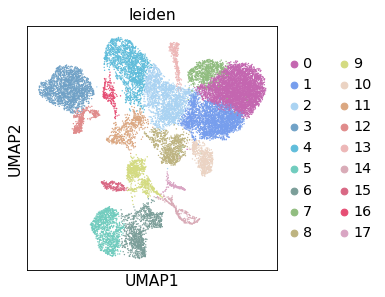

In [27]:
sc.pl.umap(adata, color = 'leiden', palette = gonads_colors)

#### Assign myeloid vs. non-myeloid

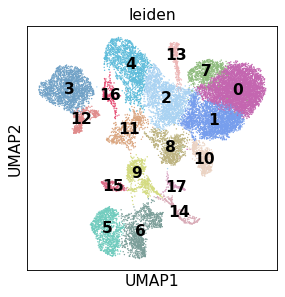

In [28]:
sc.pl.umap(adata, color = 'leiden', palette = gonads_colors, legend_loc = 'on data')

 * Myeloid lineage: 0, 1, 7, 13, 4, 2, 16, 11, 8, 10
 * Other lineages: 5, 6, 14, 15, 17, 9, 12, 3

In [35]:
lineages = {'0' : 'myeloid', '1' : 'myeloid', '7' : 'myeloid', '13' : 'myeloid', '4' : 'myeloid', '2' : 'myeloid', 
           '16' : 'myeloid', '11' : 'myeloid', '8' : 'myeloid', '10' : 'myeloid',
           '15' : 'non-myeloid', '17' : 'non-myeloid', '5' : 'non-myeloid',
            '3' : 'non-myeloid', '9' : 'non-myeloid',
           '6' : 'non-myeloid', '12' : 'non-myeloid', '14' : 'non-myeloid'}
adata.obs['lineages'] = adata.obs['leiden'].map(lineages)
adata.obs['lineages'].value_counts(dropna = False)

myeloid        13835
non-myeloid     5703
Name: lineages, dtype: int64

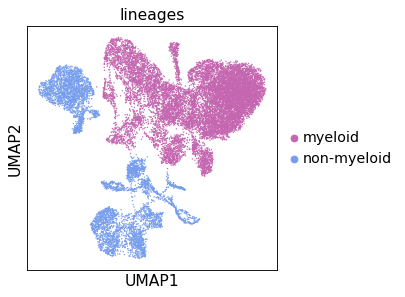

In [37]:
sc.pl.umap(adata, color = 'lineages', palette = gonads_colors, save = '_lineages_myeloid_nonMyeloid.pdf')

#### Save 

In [38]:
adata.write(path_to_gonads + 'immune_merged_lineages.h5ad')

#### Save myeloid lineage

In [39]:
myeloid = adata[[i in ['myeloid'] for i in adata.obs['lineages']]]
myeloid.shape

(13835, 20675)

In [40]:
myeloid.write(path_to_gonads + 'myeloid_merged.h5ad')

#### Save all other lineages

In [41]:
other_lineages = adata[[i not in ['myeloid'] for i in adata.obs['lineages']]]
other_lineages.shape

(5703, 20675)

In [42]:
other_lineages.write(path_to_gonads + 'other_lineages_merged.h5ad')

#### End of notebook